In [15]:
import seaborn as sns
import pandas as pd
from lightgbm import LGBMClassifier

In [3]:
train_df = pd.read_parquet('data/train.parquet')
test_df = pd.read_parquet('data/test.parquet')

In [4]:
train_df.head()

,id,rko_start_months,max_end_fact_fin_deals,max_end_plan_non_fin_deals,max_start_fin_deals,max_start_non_fin_deals,min_end_fact_fin_deals,min_end_plan_non_fin_deals,min_start_fin_deals,min_start_non_fin_deals,...,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,target_1,target_2,total_target
0,0,48.871217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.064993,33196.020871,1.229488,0.396969,323523.957625,12.420855,9.069157,1,1,1
1,1,19.530576,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.270542,33195.488147,1.229488,-0.137339,145641.572203,2.124925,2.069157,0,0,0
2,2,9.706201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,23.431839,265071.236918,4.229488,3.595162,125727.062161,0.999583,1.069157,0,0,0
3,3,92.569902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.990581,495094.276542,9.229488,8.582252,370392.322955,3.066714,3.069157,0,0,0
4,4,26.538856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.393927,33196.317418,1.229488,0.276606,125726.775788,1.219935,1.069157,0,0,0


In [5]:
test_df.head()

,id,rko_start_months,max_end_fact_fin_deals,max_end_plan_non_fin_deals,max_start_fin_deals,max_start_non_fin_deals,min_end_fact_fin_deals,min_end_plan_non_fin_deals,min_start_fin_deals,min_start_non_fin_deals,...,cnt_days_deb_g_oper_3m,sum_cred_g_oper_3m,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m
0,360000,61.061808,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.531871,51005.755087,4.275226,4.257042,33195.968822,1.229488,0.359263,301442.064297,7.049883,7.069157
1,360001,16.803743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.531871,11.888083,0.275226,0.257042,33195.968822,1.229488,0.359263,125727.663401,1.049883,1.069157
2,360002,15.448904,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.531871,11.888083,0.275226,0.257042,33195.968822,1.229488,0.359263,125727.663401,1.049883,1.069157
3,360003,11.287614,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.531871,11.888083,0.275226,0.257042,33195.968822,1.229488,0.359263,125727.663401,1.049883,1.069157
4,360004,7.997291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.531871,11.888083,0.275226,0.257042,135758.248681,2.229488,1.359263,126742.064297,2.049883,2.069157


## Basic preprocessing

In [6]:
train_df.drop(["id", "target_1", "target_2"], axis=1, inplace=True)

In [7]:
cat_cols = [
    'channel_code', 'city', 'city_type',
    'index_city_code', 'ogrn_month', 'ogrn_year',
    'branch_code', 'okved', 'segment'
]

In [8]:
train_df[cat_cols] = train_df[cat_cols].astype("category")

### Operation columns analysis

In [9]:
operation_columns = ['sum_a_oper_1m', 'sum_b_oper_1m', 'sum_c_oper_1m', 'sum_deb_d_oper_1m', 'sum_deb_e_oper_1m', 'sum_deb_f_oper_1m', 'sum_deb_g_oper_1m', 'sum_deb_h_oper_1m']
means_by_op = []
for i in operation_columns:
    means_by_op.append([train_df[train_df['total_target'] == 0][i].mean()/train_df[train_df['total_target'] == 0][i].mean(), train_df[train_df['total_target'] == 1][i].mean()/train_df[train_df['total_target'] == 0][i].mean(), train_df[i].mean()/train_df[train_df['total_target'] == 0][i].mean()])
df_to_sum = pd.DataFrame(means_by_op, columns= ['target = 0' , 'target = 1', 'total'])
mean_dict = dict()
for i in df_to_sum.columns:
    mean_dict[i] = df_to_sum[i]
mean_dict

{'target = 0': 0    1.0
 1    1.0
 2    1.0
 3    1.0
 4    1.0
 5    1.0
 6    1.0
 7    1.0
 Name: target = 0, dtype: float64,
 'target = 1': 0    1.029766
 1    1.097822
 2    0.244497
 3    0.758338
 4    0.876281
 5    0.296101
 6    0.125799
 7    1.064763
 Name: target = 1, dtype: float64,
 'total': 0    1.002093
 1    1.006879
 2    0.946873
 3    0.983006
 4    0.991300
 5    0.950502
 6    0.938527
 7    1.004554
 Name: total, dtype: float64}

## Operations columns visualization


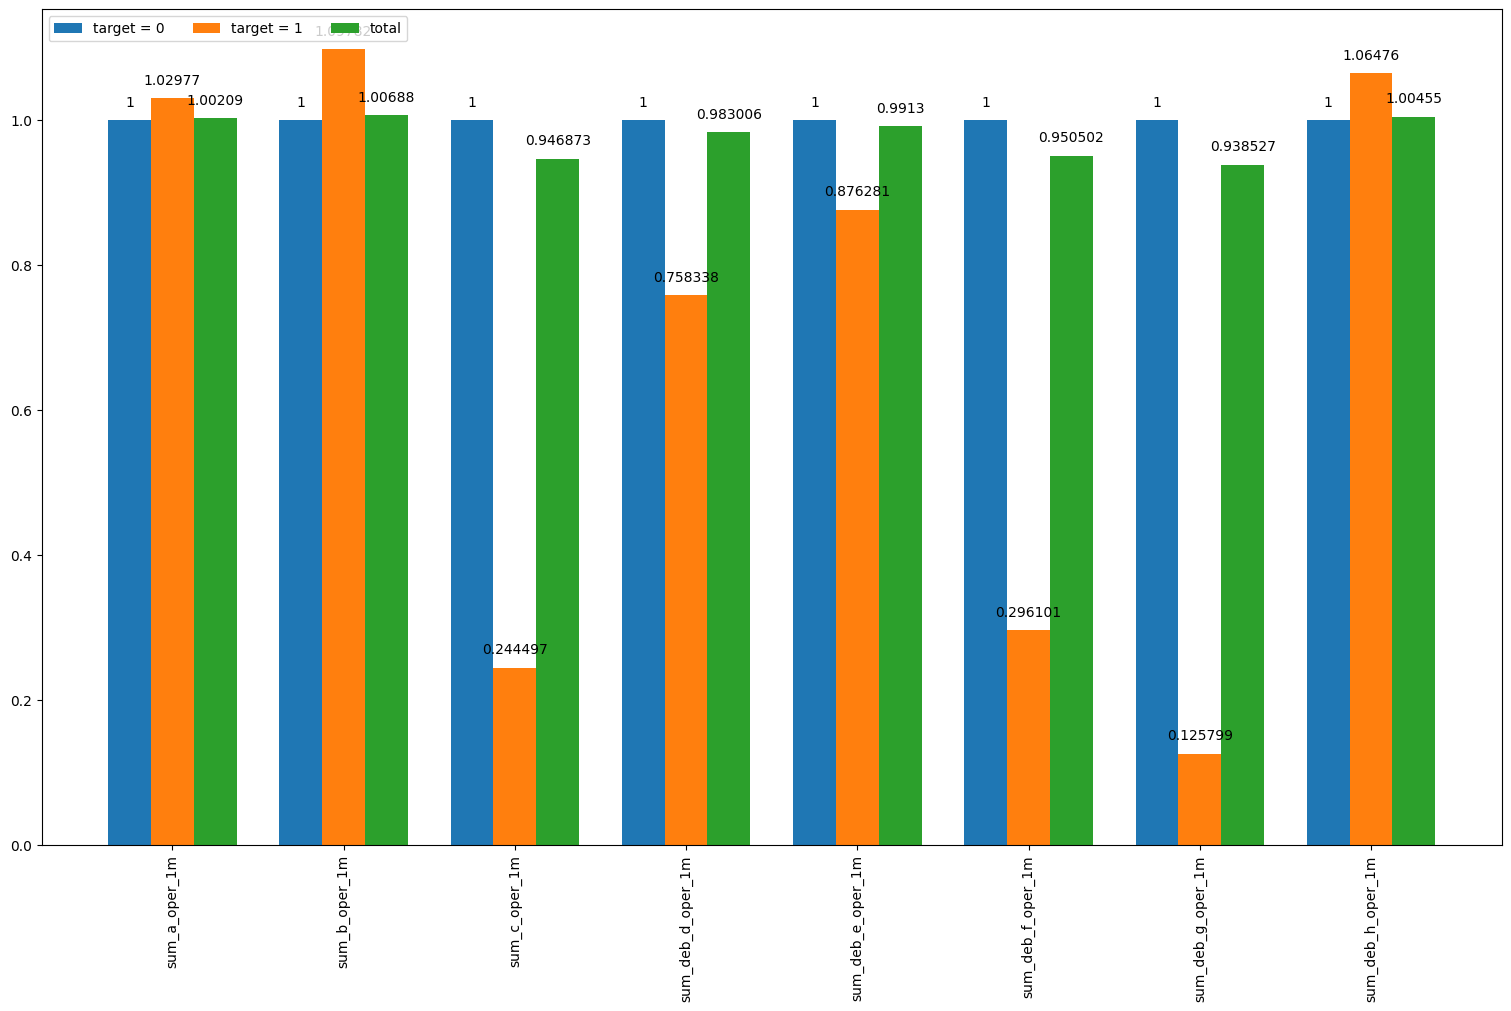

In [10]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (15, 10)
x = np.arange(len(operation_columns))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained' )

for attribute, measurement in mean_dict.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=len(operation_columns))
    multiplier += 1

ax.set_xticks(x + width, operation_columns)
ax.legend(loc='upper left', ncols=len(operation_columns))
plt.xticks(rotation=90)
plt.show()

Columns where large difference along target column: c, f, g

What about 3m?

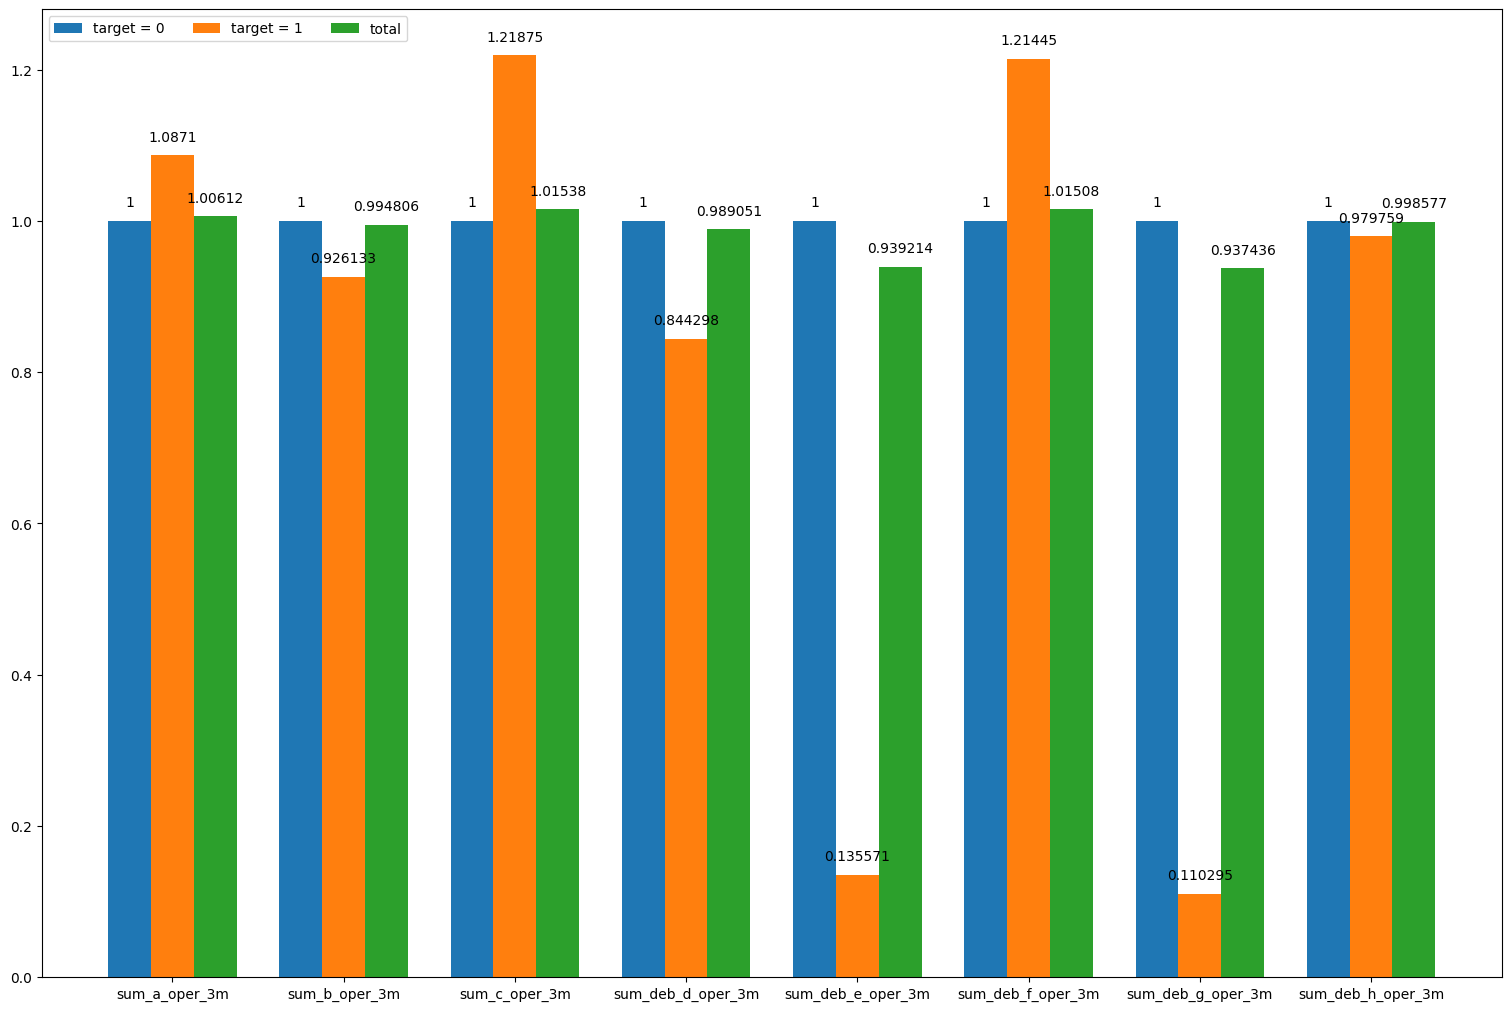

In [11]:
operation_columns = ['sum_a_oper_3m', 'sum_b_oper_3m', 'sum_c_oper_3m', 'sum_deb_d_oper_3m', 'sum_deb_e_oper_3m', 'sum_deb_f_oper_3m', 'sum_deb_g_oper_3m', 'sum_deb_h_oper_3m']
means_by_op = []
for i in operation_columns:
    means_by_op.append([train_df[train_df['total_target'] == 0][i].mean()/train_df[train_df['total_target'] == 0][i].mean(), train_df[train_df['total_target'] == 1][i].mean()/train_df[train_df['total_target'] == 0][i].mean(), train_df[i].mean()/train_df[train_df['total_target'] == 0][i].mean()])
df_to_sum = pd.DataFrame(means_by_op, columns= ['target = 0' , 'target = 1', 'total'])
mean_dict = dict()
for i in df_to_sum.columns:
    mean_dict[i] = df_to_sum[i]
plt.rcParams["figure.figsize"] = (15, 10)
x = np.arange(len(operation_columns))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in mean_dict.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=len(operation_columns))
    multiplier += 1

ax.set_xticks(x + width, operation_columns)
ax.legend(loc='upper left', ncols=len(operation_columns))
plt.show()

When working with 3m columns - large difference at columns: у, e, f

What about "count"?

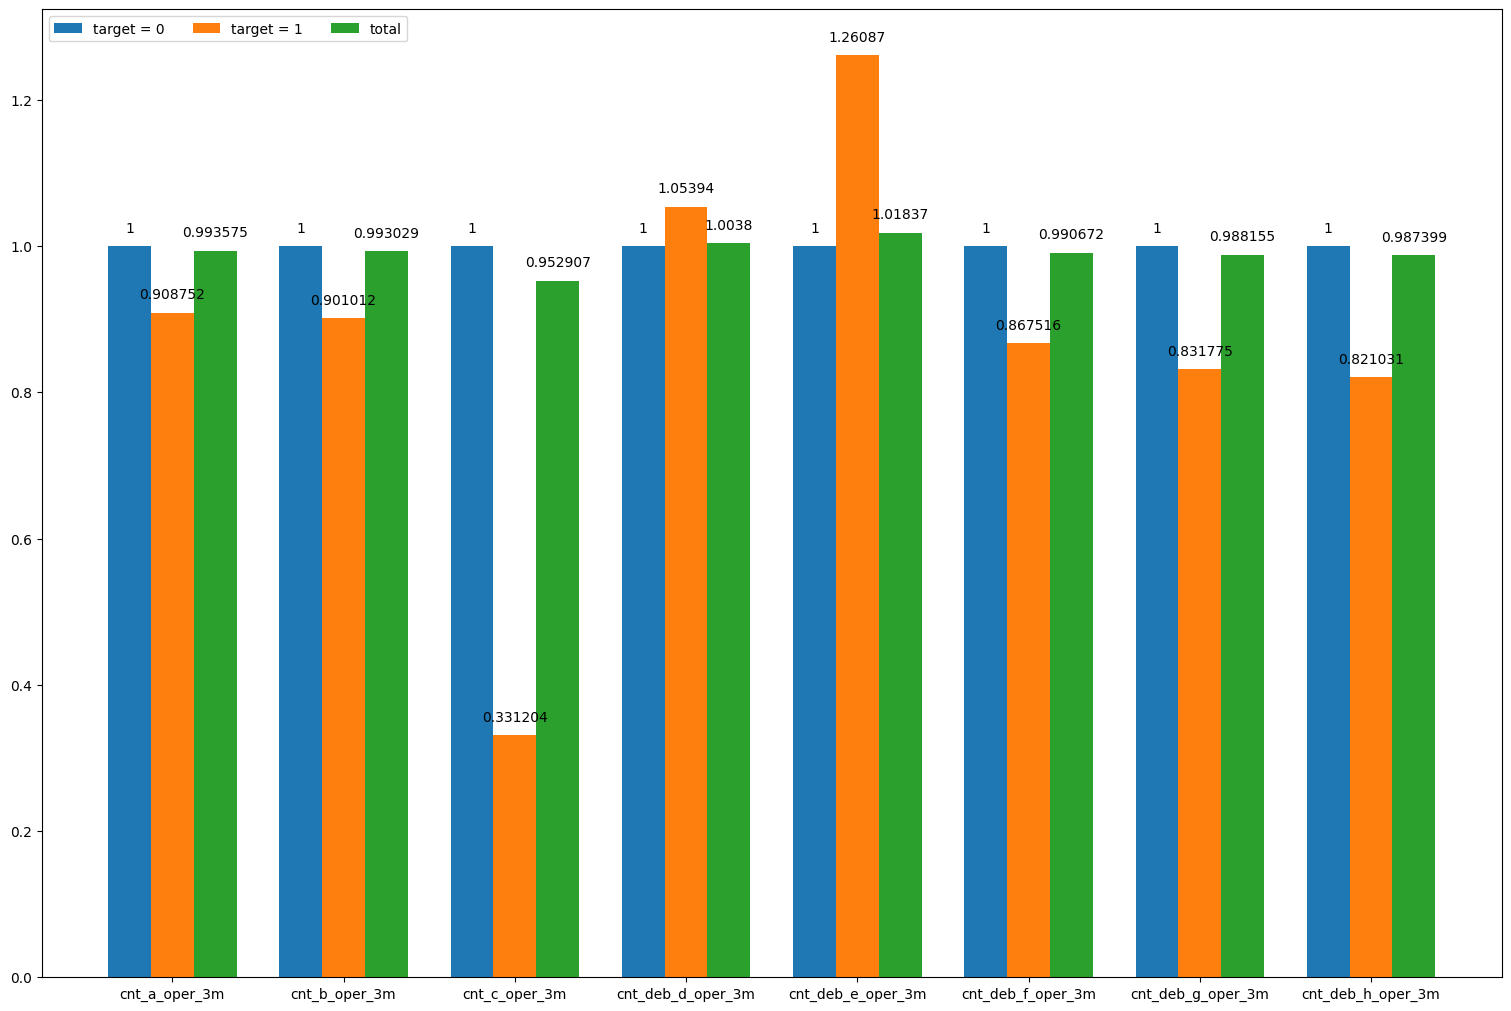

In [12]:
operation_columns = ['cnt_a_oper_3m', 'cnt_b_oper_3m', 'cnt_c_oper_3m', 'cnt_deb_d_oper_3m', 'cnt_deb_e_oper_3m', 'cnt_deb_f_oper_3m', 'cnt_deb_g_oper_3m', 'cnt_deb_h_oper_3m']
means_by_op = []
for i in operation_columns:
    means_by_op.append([train_df[train_df['total_target'] == 0][i].mean()/train_df[train_df['total_target'] == 0][i].mean(), train_df[train_df['total_target'] == 1][i].mean()/train_df[train_df['total_target'] == 0][i].mean(), train_df[i].mean()/train_df[train_df['total_target'] == 0][i].mean()])
df_to_sum = pd.DataFrame(means_by_op, columns= ['target = 0' , 'target = 1', 'total'])
mean_dict = dict()
for i in df_to_sum.columns:
    mean_dict[i] = df_to_sum[i]
plt.rcParams["figure.figsize"] = (15, 10)
x = np.arange(len(operation_columns))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in mean_dict.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=len(operation_columns))
    multiplier += 1

ax.set_xticks(x + width, operation_columns)
ax.legend(loc='upper left', ncols=len(operation_columns))

The amount of "c" operations dramatically decreases at 3m scale.

What about 1m?

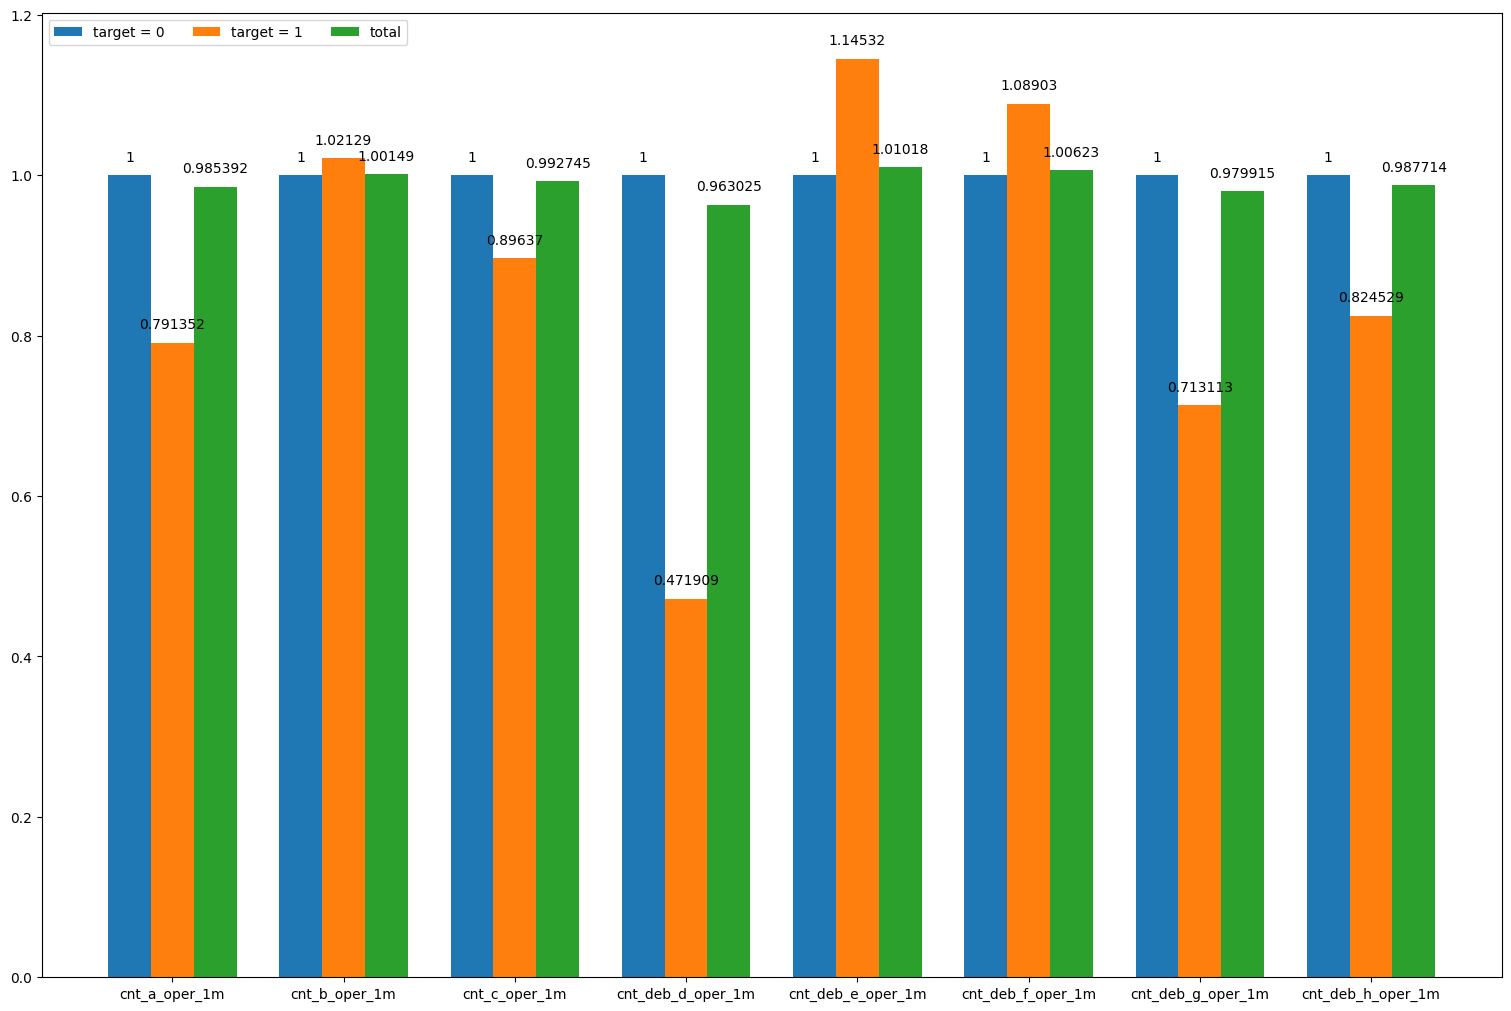

In [13]:
operation_columns = ['cnt_a_oper_1m', 'cnt_b_oper_1m', 'cnt_c_oper_1m', 'cnt_deb_d_oper_1m', 'cnt_deb_e_oper_1m', 'cnt_deb_f_oper_1m', 'cnt_deb_g_oper_1m', 'cnt_deb_h_oper_1m']
means_by_op = []
for i in operation_columns:
    means_by_op.append([train_df[train_df['total_target'] == 0][i].mean()/train_df[train_df['total_target'] == 0][i].mean(), train_df[train_df['total_target'] == 1][i].mean()/train_df[train_df['total_target'] == 0][i].mean(), train_df[i].mean()/train_df[train_df['total_target'] == 0][i].mean()])
df_to_sum = pd.DataFrame(means_by_op, columns= ['target = 0' , 'target = 1', 'total'])
mean_dict = dict()
for i in df_to_sum.columns:
    mean_dict[i] = df_to_sum[i]
plt.rcParams["figure.figsize"] = (15, 10)
x = np.arange(len(operation_columns))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in mean_dict.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=len(operation_columns))
    multiplier += 1

ax.set_xticks(x + width, operation_columns)
ax.legend(loc='upper left', ncols=len(operation_columns))

Here the amount of "d" operations decreases.

Let's see how sum of operations decreases on whole:

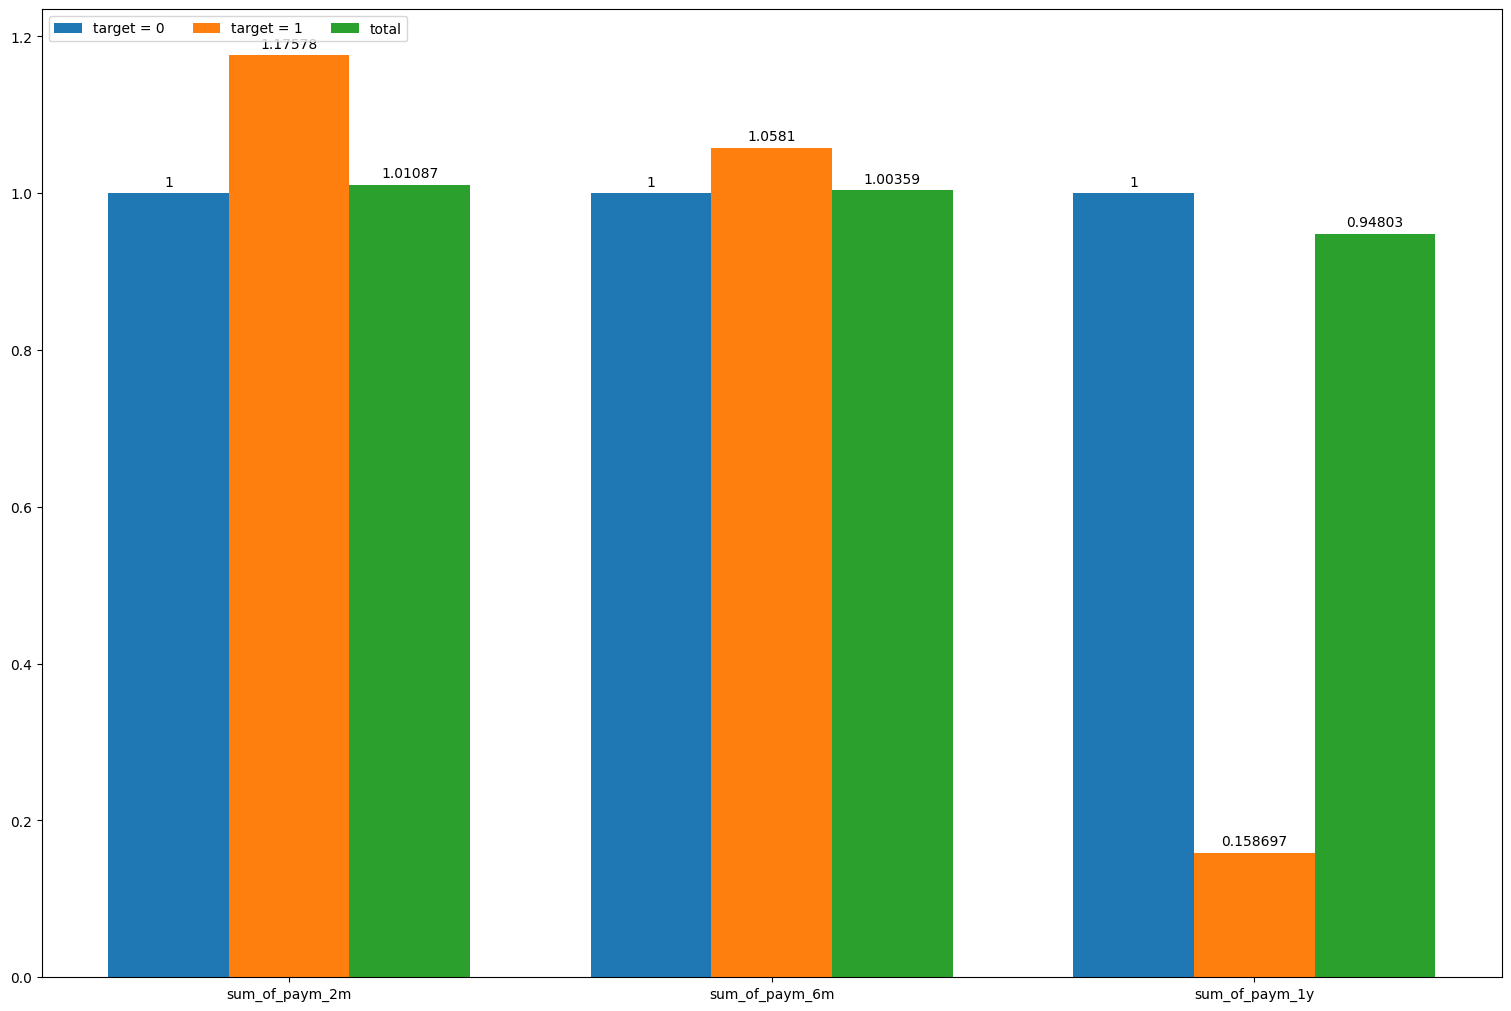

In [14]:
operation_columns = ['sum_of_paym_2m', 'sum_of_paym_6m', 'sum_of_paym_1y']
means_by_op = []
for i in operation_columns:
    means_by_op.append([train_df[train_df['total_target'] == 0][i].mean()/train_df[train_df['total_target'] == 0][i].mean(), train_df[train_df['total_target'] == 1][i].mean()/train_df[train_df['total_target'] == 0][i].mean(), train_df[i].mean()/train_df[train_df['total_target'] == 0][i].mean()])
df_to_sum = pd.DataFrame(means_by_op, columns= ['target = 0' , 'target = 1', 'total'])
mean_dict = dict()
for i in df_to_sum.columns:
    mean_dict[i] = df_to_sum[i]
plt.rcParams["figure.figsize"] = (15, 10)
x = np.arange(len(operation_columns))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in mean_dict.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=len(operation_columns))
    multiplier += 1

ax.set_xticks(x + width, operation_columns)
ax.legend(loc='upper left', ncols=len(operation_columns))

"okved" column affects, let's analyse it more precisely

<AxesSubplot: ylabel='okved'>

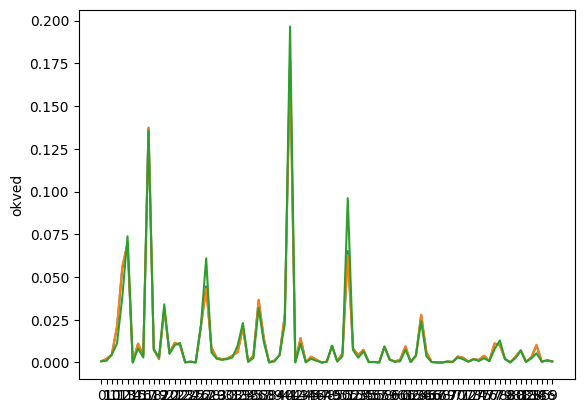

In [249]:
sns.lineplot(x = train_df['okved'].value_counts().index,y = train_df['okved'].value_counts()/len(train_df))
sns.lineplot(x = train_df[train_df['total_target'] == 0]['okved'].value_counts().index,y = train_df[train_df['total_target'] == 0]['okved'].value_counts()/len(train_df[train_df['total_target'] == 0]))
sns.lineplot(x = train_df[train_df['total_target'] == 1]['okved'].value_counts().index,y = train_df[train_df['total_target'] == 1]['okved'].value_counts()/len(train_df[train_df['total_target'] == 1]))

Analyzing "city" column

<AxesSubplot: ylabel='city'>

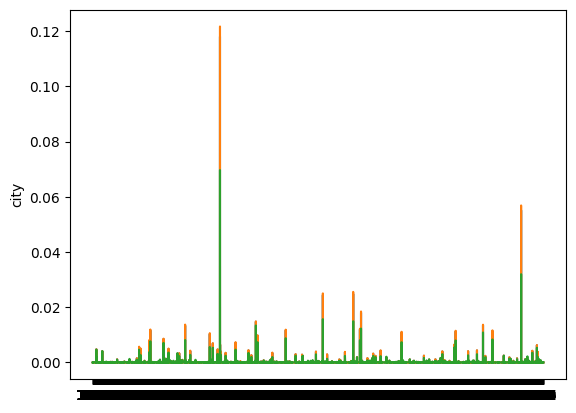

In [251]:
sns.lineplot(x = train_df['city'].value_counts().index,y = train_df['city'].value_counts()/len(train_df))
sns.lineplot(x = train_df[train_df['total_target'] == 0]['city'].value_counts().index,y = train_df[train_df['total_target'] == 0]['city'].value_counts()/len(train_df[train_df['total_target'] == 0]))
sns.lineplot(x = train_df[train_df['total_target'] == 1]['city'].value_counts().index,y = train_df[train_df['total_target'] == 1]['city'].value_counts()/len(train_df[train_df['total_target'] == 1]))